# Monte Carlo Exploring starts

### Abstract:

This notebook contains the implementation of Monte Carlo exploring starts for Grid world game.


In [1]:
# Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl
# the Monte Carlo Exploring-Starts method to find the optimal policy
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [2]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # each triple s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [3]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [4]:
grid = negative_grid(step_cost=-0.9)
# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|


In [5]:
# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  R  |  L  |  D  |     |
---------------------------
  R  |     |  R  |     |
---------------------------
  R  |  L  |  D  |  U  |


In [6]:
# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0 # needs to be initialized to something so we can argmax it
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass

# initial Q values for all states in grid
print(Q)

{(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


In [7]:
# repeat until convergence
deltas = []
for t in range(2000):
  # generate an episode using pi
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    sa = (s, a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  # update policy
  for s in policy.keys():
    policy[s] = max_dict(Q[s])[0]

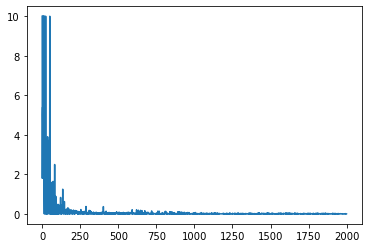

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  U  |


In [8]:
plt.plot(deltas)
plt.show()

print("final policy:")
print_policy(policy, grid)

In [9]:
# find V
V = {}
for s, Qs in Q.items():
  V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

final values:
---------------------------
-1.74|-0.79| 1.00| 0.00|
---------------------------
-2.50| 0.00|-0.73| 0.00|
---------------------------
-3.24|-2.96|-1.89|-1.00|


### Conclusion:

The above cell shows the final values for Monte Carlo exploring starts for Gird world game

